# ENV reward sweep (updated for new ENV knobs)
This notebook sweeps `C4/connect4_env.py` shaping weights by evaluating a simple **greedy reward agent** against a small opponent set.

Notes:
- Knobs are pulled directly from `Connect4Env` (single source of truth).
- The greedy agent picks the move that maximizes **immediate ENV reward**.
- Metric: win/draw/loss (PPG = 1/0.5/0).


In [1]:
import itertools, copy, math, time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import copy
import numpy as np

from C4.connect4_env import Connect4Env
from C4.fast_connect4_lookahead import Connect4Lookahead


In [2]:
# ---------------------------- Defaults + sweep grid ----------------------------

# Pull defaults directly from ENV (so changes in connect4_env.py automatically reflect here).
ENV_DEFAULTS = {k: float(getattr(Connect4Env, k)) for k in [
    # base threat/block
    "THREAT2_VALUE","THREAT3_VALUE","BLOCK2_VALUE","BLOCK3_VALUE",
    # vertical bias
    "VERT_THREAT_MUL_2","VERT_THREAT_MUL_3","VERT_BLOCK_MUL_2","VERT_BLOCK_MUL_3",
    # center / opening
    "CENTER_REWARD","CENTER_REWARD_BOTTOM","OPENING_DECAY_STEPS",
    # fork / sanity
    "FORK_BONUS","BLOCK_FORK_BONUS","OPP_IMMEDIATE_PENALTY",
    # allis-ish env shaping
    "PARITY_MOVE_BONUS","PARITY_UNLOCK_PENALTY","TEMPO_SQUEEZE_W","THREATSPACE_W",
    # misc
    "STEP_PENALTY",
]}

# Edit me: keep small, then expand once you see direction.
GRID = {
    "THREAT2_VALUE":        [5.0],
    "THREAT3_VALUE":        [10.0],
    "BLOCK2_VALUE":         [5.0],
    "BLOCK3_VALUE":         [20.0],

    "VERT_THREAT_MUL_2":    [1.1],
    "VERT_THREAT_MUL_3":    [1.5],
    "VERT_BLOCK_MUL_2":     [1.5],
    "VERT_BLOCK_MUL_3":     [1.25, 1.5, 2, 3],

    "CENTER_REWARD":        [0.1],
    "CENTER_REWARD_BOTTOM": [1000],
    "OPENING_DECAY_STEPS":  [7],

    "FORK_BONUS":           [25.0],
    "BLOCK_FORK_BONUS":     [30.0],
    "OPP_IMMEDIATE_PENALTY":[1000.0],

    "PARITY_MOVE_BONUS":     [0.30],
    "PARITY_UNLOCK_PENALTY": [0.10],
    "TEMPO_SQUEEZE_W":       [0.15],
    "THREATSPACE_W":         [1.25],

    "STEP_PENALTY":          [1],
}

MAX_VARIANTS = 256

def iter_cfgs(grid: dict):
    keys = list(grid.keys())
    vals = [grid[k] for k in keys]
    for tup in itertools.product(*vals):
        yield dict(zip(keys, tup))

N = math.prod(len(v) for v in GRID.values())
print("Grid sizes:", {k: len(v) for k,v in GRID.items()})
print("Total variants:", N, "(cap:", MAX_VARIANTS, ")")
assert N <= MAX_VARIANTS, "Reduce GRID or increase MAX_VARIANTS knowingly."


Grid sizes: {'THREAT2_VALUE': 1, 'THREAT3_VALUE': 1, 'BLOCK2_VALUE': 1, 'BLOCK3_VALUE': 1, 'VERT_THREAT_MUL_2': 1, 'VERT_THREAT_MUL_3': 1, 'VERT_BLOCK_MUL_2': 1, 'VERT_BLOCK_MUL_3': 4, 'CENTER_REWARD': 1, 'CENTER_REWARD_BOTTOM': 1, 'OPENING_DECAY_STEPS': 1, 'FORK_BONUS': 1, 'BLOCK_FORK_BONUS': 1, 'OPP_IMMEDIATE_PENALTY': 1, 'PARITY_MOVE_BONUS': 1, 'PARITY_UNLOCK_PENALTY': 1, 'TEMPO_SQUEEZE_W': 1, 'THREATSPACE_W': 1, 'STEP_PENALTY': 1}
Total variants: 4 (cap: 256 )


In [3]:
class GreedyRewardAgent:
    """Chooses the move with the highest immediate ENV reward (from mover POV)."""
    def __init__(self, name="GreedyReward"):
        self.name = name

    def act(self, env: Connect4Env):
        legal = env.available_actions()
        if not legal:
            return 0

        best_a = legal[0]
        best_score = -1e18

        for a in legal:
            e2 = copy.deepcopy(env)
            mover = int(e2.current_player)     # mover BEFORE the step
            _, r, done = e2.step(a)

            # Tie-break: prefer immediate wins if reward ties
            win_nudge = 0.0
            if done and int(e2.winner) == mover:
                win_nudge = 1e-6

            score = float(r) + win_nudge
            if score > best_score:
                best_score = score
                best_a = a

        return int(best_a)

class RandomAgent:
    def __init__(self, rng, name="Random"):
        self.rng = rng
        self.name = name
    def act(self, env):
        legal = env.available_actions()
        return int(self.rng.choice(legal)) if legal else 0

class LookaheadAgent:
    def __init__(self, depth:int, lookahead: Connect4Lookahead, name=None):
        self.depth = int(depth)
        self.lookahead = lookahead
        self.name = name or f"L{depth}"
    def act(self, env: Connect4Env):
        # env.board is top-first with +/-1 pieces; player mark is env.current_player
        return int(self.lookahead.n_step_lookahead(env.board, env.current_player, depth=self.depth))

def _score_from_pov(winner: int, pov_mark: int) -> float:
    """winner in {+1,-1,0}, pov_mark in {+1,-1}."""
    if winner == 0:
        return 0.5
    return 1.0 if winner == pov_mark else 0.0

def play_game(agent_plus, agent_minus, env: Connect4Env):
    """
    Plays one game with:
      - agent_plus controlling env.current_player==+1 turns
      - agent_minus controlling env.current_player==-1 turns
    Returns (winner, score_plus) where score_plus is from +1 POV.
    """
    env.reset()
    while not env.done:
        a = agent_plus.act(env) if env.current_player == 1 else agent_minus.act(env)
        _, _, done = env.step(a)
        if done:
            break
    w = int(env.winner)  # +1, -1, or 0
    return w, _score_from_pov(w, pov_mark=+1)

def eval_vs_opponents(cfg: dict, games_per_opp=40, seed=0):
    rng = np.random.default_rng(seed)
    look = Connect4Lookahead()

    # Build env and apply cfg to the instance (keeps class clean)
    env = Connect4Env()
    for k, v in cfg.items():
        setattr(env, k, float(v))

    me = GreedyRewardAgent(name="GreedyReward")

    opponents = [
        RandomAgent(rng, name="Random"),
        LookaheadAgent(1, look, name="L1"),
        LookaheadAgent(3, look, name="L3"),
        LookaheadAgent(5, look, name="L5"),
    ]

    out = {}
    for opp in opponents:
        scores = []
        for g in range(games_per_opp):
            if (g & 1) == 0:
                # me is +1
                w, score_plus = play_game(me, opp, env)
                scores.append(score_plus)               # from me POV (+1)
            else:
                # me is -1
                w, score_plus = play_game(opp, me, env)
                scores.append(_score_from_pov(w, pov_mark=-1))  # from me POV (-1)
        out[opp.name] = float(np.mean(scores))
    return out

In [4]:
# ---------------------------- Run sweep ----------------------------

SEED = 666
GAMES_PER_OPP = 10  # raise when narrowing down

results = []
for i, cfg in enumerate(tqdm(list(iter_cfgs(GRID)), desc="variants")):
    scores = eval_vs_opponents(cfg, games_per_opp=GAMES_PER_OPP, seed=SEED+i)
    row = dict(cfg)
    row["variant"] = f"V{i:02d}"
    row["variant_i"] = i
    row["seed"] = SEED + i
    row.update({f"PPG_{k}": v for k, v in scores.items()})
    row["meta"] = float(sum(scores.values()))
    results.append(row)

df_raw = pd.DataFrame(results)  # unsorted (keeps sweep order)
df = df_raw.sort_values(["meta", "variant_i"], ascending=[False, True]).reset_index(drop=True)

df.head(10)


variants:   0%|          | 0/4 [00:00<?, ?it/s]

,THREAT2_VALUE,THREAT3_VALUE,BLOCK2_VALUE,BLOCK3_VALUE,VERT_THREAT_MUL_2,VERT_THREAT_MUL_3,VERT_BLOCK_MUL_2,VERT_BLOCK_MUL_3,CENTER_REWARD,CENTER_REWARD_BOTTOM,...,THREATSPACE_W,STEP_PENALTY,variant,variant_i,seed,PPG_Random,PPG_L1,PPG_L3,PPG_L5,meta
0,5.0,10.0,5.0,20.0,1.1,1.5,1.5,1.25,0.1,1000,...,1.25,1,V00,0,666,1.0,0.0,0.5,0.0,1.5
1,5.0,10.0,5.0,20.0,1.1,1.5,1.5,1.50,0.1,1000,...,1.25,1,V01,1,667,1.0,0.0,0.5,0.0,1.5
2,5.0,10.0,5.0,20.0,1.1,1.5,1.5,2.00,0.1,1000,...,1.25,1,V02,2,668,1.0,0.0,0.5,0.0,1.5
3,5.0,10.0,5.0,20.0,1.1,1.5,1.5,3.00,0.1,1000,...,1.25,1,V03,3,669,1.0,0.0,0.5,0.0,1.5


## Tournament evaluation: metascore + heatmap + yardstick vs Lookahead opponents


Built VARIANTS from GRID: 4 variants
Tournament variants: 4


,V00,V01,V02,V03
V00,NaN,0.5,0.60,0.50
V01,0.5,NaN,0.50,0.40
V02,0.4,0.5,NaN,0.65
V03,0.5,0.6,0.35,NaN


,name,metascore
0,V00,0.533333
1,V02,0.516667
2,V03,0.483333
3,V01,0.466667


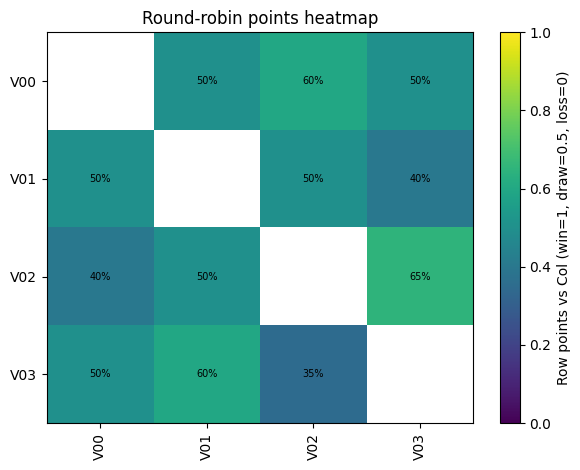

,variant,opp,points,wins,losses,draws,games
0,V00,L1,0.150,3,17,0,20
1,V00,L2,0.000,0,20,0,20
2,V00,L3,0.450,9,11,0,20
3,V00,L5,0.050,1,19,0,20
4,V00,L7,0.225,0,11,9,20
5,V01,L1,0.050,1,19,0,20
6,V01,L2,0.000,0,20,0,20
7,V01,L3,0.500,10,10,0,20
8,V01,L5,0.000,0,20,0,20
9,V01,L7,0.225,0,11,9,20


opp,L1,L2,L3,L5,L7
variant,,,,,
V00,0.15,0.0,0.45,0.05,0.225
V01,0.05,0.0,0.50,0.00,0.225
V02,0.10,0.0,0.55,0.00,0.225
V03,0.20,0.0,0.50,0.05,0.200


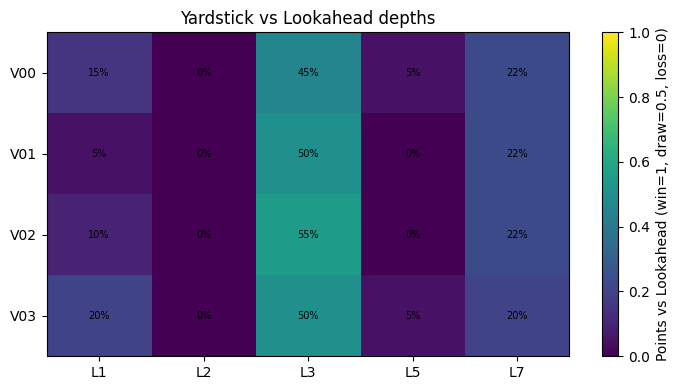

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Any

# We assume Connect4Env and Connect4Lookahead are already available in the notebook scope.

# ----------------------------- policy wrappers -----------------------------

@dataclass
class RewardGreedyPolicy:
    """Greedy: pick action with max immediate ENV reward (1-ply)."""
    name: str
    env_params: Dict[str, Any]

    def _make_env(self):
        e = Connect4Env()
        # Override knobs on the INSTANCE (step() reads via self.*)
        for k, v in self.env_params.items():
            setattr(e, k, v)
        # Keep derived arrays consistent if these are swept
        if "CENTER_WEIGHTS" in self.env_params:
            e._CENTER_WEIGHTS_ARR = np.asarray(e.CENTER_WEIGHTS, dtype=np.float32)
        return e

    def act(self, base_env: "Connect4Env", rng: np.random.Generator) -> int:
        legal = base_env.available_actions()
        if not legal:
            return 0

        best_a = int(legal[0])
        best_r = -1e18

        for a in legal:
            e = self._make_env()

            # copy state from base_env (minimal set)
            e.board = base_env.board.copy()
            e.current_player = int(base_env.current_player)
            e.done = bool(base_env.done)
            e.winner = None if base_env.winner is None else int(base_env.winner)
            e.ply = int(base_env.ply)

            e._pos1 = np.uint64(base_env._pos1)
            e._pos2 = np.uint64(base_env._pos2)
            e._mask = np.uint64(base_env._mask)
            e._heights = base_env._heights.copy()

            _, r, _ = e.step(int(a))
            if float(r) > best_r:
                best_r = float(r)
                best_a = int(a)

        return int(best_a)


@dataclass
class LookaheadPolicy:
    """Bitboard lookahead policy (uses Connect4Lookahead)."""
    name: str
    depth: int
    weights: Optional[Dict[int, float]] = None

    def __post_init__(self):
        self.la = Connect4Lookahead(weights=self.weights)

    def act(self, base_env: "Connect4Env", rng: np.random.Generator) -> int:
        player = int(base_env.current_player)  # env uses +1/-1 which Lookahead accepts
        return int(self.la.n_step_lookahead(base_env.board, player, depth=int(self.depth)))


# ----------------------------- opening noise -----------------------------

def noisy_opening_pick(scores: Dict[int, float], legal: list, opening_noise_k: Dict[int, float], rng: np.random.Generator) -> int:
    """
    scores: dict[action] -> score
    opening_noise_k: {0:p0, 1:p1, 2:p2} where k controls 'uniform among top-(k+1)'
    """
    if not legal:
        return 0

    ks = np.array(sorted(opening_noise_k.keys()), dtype=np.int32)
    ps = np.array([opening_noise_k[k] for k in ks], dtype=np.float64)
    ps = ps / ps.sum()
    k = int(rng.choice(ks, p=ps))

    ranked = sorted(legal, key=lambda a: float(scores.get(int(a), -1e18)), reverse=True)
    topn = min(len(ranked), k + 1)
    cand = ranked[:topn]
    return int(rng.choice(np.array(cand, dtype=np.int32)))


# ----------------------------- game runner -----------------------------

def play_game(policy1, policy2, seed=0, opening_ply_limit=2, opening_noise_k=None) -> int:
    """
    policy1: plays as +1
    policy2: plays as -1
    Returns winner: +1 / -1 / 0 (draw)
    """
    rng = np.random.default_rng(int(seed))
    env = Connect4Env()
    env.reset()

    while True:
        if env.done:
            return int(env.winner if env.winner is not None else 0)

        mover = int(env.current_player)
        pol = policy1 if mover == 1 else policy2

        # Opening noise only for RewardGreedyPolicy (cheap to score top-k)
        if opening_noise_k is not None and env.ply < int(opening_ply_limit) and isinstance(pol, RewardGreedyPolicy):
            legal = env.available_actions()
            scores = {}
            for a in legal:
                e = pol._make_env()
                e.board = env.board.copy()
                e.current_player = int(env.current_player)
                e.done = bool(env.done)
                e.winner = None if env.winner is None else int(env.winner)
                e.ply = int(env.ply)
                e._pos1 = np.uint64(env._pos1)
                e._pos2 = np.uint64(env._pos2)
                e._mask = np.uint64(env._mask)
                e._heights = env._heights.copy()
                _, r, _ = e.step(int(a))
                scores[int(a)] = float(r)
            a = noisy_opening_pick(scores, legal, opening_noise_k, rng)
        else:
            a = int(pol.act(env, rng))

        _, _, done = env.step(int(a))
        if done:
            return int(env.winner)


def match_points(winner: int, row_player_mark: int) -> float:
    # win=1, draw=0.5, loss=0 from the row player's POV
    if winner == 0:
        return 0.5
    return 1.0 if int(winner) == int(row_player_mark) else 0.0


def play_match(row_pol, col_pol, games_per_side=10, seed=0, opening_ply_limit=2, opening_noise_k=None):
    rng = np.random.default_rng(int(seed))
    pts = 0.0
    wins = losses = draws = 0

    # row starts as +1
    for _ in range(int(games_per_side)):
        w = play_game(row_pol, col_pol, seed=int(rng.integers(0, 2**31 - 1)),
                      opening_ply_limit=opening_ply_limit, opening_noise_k=opening_noise_k)
        pts += match_points(w, +1)
        wins += int(w == 1)
        losses += int(w == -1)
        draws += int(w == 0)

    # row starts as -1
    for _ in range(int(games_per_side)):
        w = play_game(col_pol, row_pol, seed=int(rng.integers(0, 2**31 - 1)),
                      opening_ply_limit=opening_ply_limit, opening_noise_k=opening_noise_k)
        pts += match_points(w, -1)
        wins += int(w == -1)
        losses += int(w == 1)
        draws += int(w == 0)

    total = 2 * int(games_per_side)
    return {
        "points": pts / total,
        "wins": int(wins),
        "losses": int(losses),
        "draws": int(draws),
        "games": int(total),
    }


# ----------------------------- build variants -----------------------------

if "VARIANTS" not in globals():
    # Be robust to out-of-order execution: if the sweep cell wasn't run,
    # (re)build variants from GRID here.
    if "GRID" not in globals():
        raise NameError("Expected GRID (dict of parameter -> list of values). Run the sweep cell first.")
    from itertools import product
    keys = list(GRID.keys())
    vals = [GRID[k] for k in keys]
    VARIANTS = [{"name": f"V{i:02d}", "params": dict(zip(keys, combo))} for i, combo in enumerate(product(*vals))]
    if "MAX_VARIANTS" in globals():
        assert len(VARIANTS) <= int(MAX_VARIANTS), f"Too many variants: {len(VARIANTS)} > {MAX_VARIANTS}"
    print(f"Built VARIANTS from GRID: {len(VARIANTS)} variants")

policies = [RewardGreedyPolicy(name=v.get("name", f"V{i:02d}"), env_params=v["params"]) for i, v in enumerate(VARIANTS)]
names = [p.name for p in policies]
N = len(policies)

print("Tournament variants:", N)

# ----------------------------- round robin -----------------------------

OPENING_NOISE_K = globals().get("OPENING_NOISE_K", {0: 0.70, 1: 0.20, 2: 0.10})
OPENING_PLY_LIMIT = globals().get("OPENING_PLY_LIMIT", 2)
GAMES_PER_PAIR = globals().get("GAMES_PER_PAIR", 10)
SEED = globals().get("SEED", 666)

P = np.full((N, N), np.nan, dtype=np.float64)

for i in range(N):
    for j in range(i + 1, N):
        res = play_match(
            policies[i], policies[j],
            games_per_side=GAMES_PER_PAIR,
            seed=SEED + 10_000 * i + 101 * j,
            opening_ply_limit=OPENING_PLY_LIMIT,
            opening_noise_k=OPENING_NOISE_K,
        )
        P[i, j] = res["points"]
        P[j, i] = 1.0 - res["points"]  # points symmetry with draw=0.5

df_P = pd.DataFrame(P, index=names, columns=names)
display(df_P)

metas = []
for i in range(N):
    row = [P[i, j] for j in range(N) if j != i and np.isfinite(P[i, j])]
    metas.append(float(np.mean(row)) if row else float("nan"))

df_meta = pd.DataFrame({"name": names, "metascore": metas}).sort_values("metascore", ascending=False).reset_index(drop=True)
display(df_meta)

# Heatmap with % annotations
plt.figure(figsize=(0.6 * max(10, N), 0.6 * max(8, N)))
plt.imshow(P, aspect="auto", vmin=0.0, vmax=1.0)
plt.colorbar(label="Row points vs Col (win=1, draw=0.5, loss=0)")
plt.xticks(range(N), names, rotation=90)
plt.yticks(range(N), names)

for i in range(N):
    for j in range(N):
        if i == j or not np.isfinite(P[i, j]):
            continue
        plt.text(j, i, f"{100*P[i,j]:.0f}%", ha="center", va="center", fontsize=7)

plt.title("Round-robin points heatmap")
plt.tight_layout()
plt.show()

# ----------------------------- yardstick vs Lookahead -----------------------------

LOOKAHEAD_DEPTHS = globals().get("LOOKAHEAD_DEPTHS", [1, 2, 3, 5, 7])

yardstick = []
for i, pol in enumerate(policies):
    for d in LOOKAHEAD_DEPTHS:
        opp = LookaheadPolicy(name=f"LA_L{d}", depth=int(d))
        res = play_match(
            pol, opp,
            games_per_side=GAMES_PER_PAIR,
            seed=SEED + 777_000 + 1000 * i + d,
            opening_ply_limit=OPENING_PLY_LIMIT,
            opening_noise_k=OPENING_NOISE_K,
        )
        yardstick.append({
            "variant": pol.name,
            "opp": f"L{d}",
            "points": res["points"],
            "wins": res["wins"],
            "losses": res["losses"],
            "draws": res["draws"],
            "games": res["games"],
        })

df_yard = pd.DataFrame(yardstick)
display(df_yard)

df_yard_pivot = df_yard.pivot_table(index="variant", columns="opp", values="points")
display(df_yard_pivot)

plt.figure(figsize=(0.9 * max(8, len(df_yard_pivot.columns)), 0.5 * max(8, len(df_yard_pivot.index))))
plt.imshow(df_yard_pivot.values, aspect="auto", vmin=0.0, vmax=1.0)
plt.colorbar(label="Points vs Lookahead (win=1, draw=0.5, loss=0)")
plt.xticks(range(len(df_yard_pivot.columns)), df_yard_pivot.columns, rotation=0)
plt.yticks(range(len(df_yard_pivot.index)), df_yard_pivot.index)

for i in range(df_yard_pivot.shape[0]):
    for j in range(df_yard_pivot.shape[1]):
        v = df_yard_pivot.values[i, j]
        if np.isfinite(v):
            plt.text(j, i, f"{100*v:.0f}%", ha="center", va="center", fontsize=7)

plt.title("Yardstick vs Lookahead depths")
plt.tight_layout()
plt.show()